# Breeden-Litzenberger formula for risk-neutral densities

<b> YouTube Tutorial </b> (Published: Jun 6, 2022): https://youtu.be/O3LuuOnPW8U

The Feynman–Kac analysis enables us to define a risk neutral probability in which we can price options. Let $f_\mathbb{Q}(S_T)$ denote the terminal risk neutral ($\mathbb{Q}$-measure) probability at time $T$ , and let $F_\mathbb{Q}(S_T)$ denote the cumulative probability. A European call option at time $t$, expiring at $T$ , with strike price $K$, is priced ($\tau = T - t$):

$\large C(K, \tau) = \large E_\mathbb{Q}[e^{-r\tau} (S_T - K)^+]$

$\large C(K, \tau) = e^{-r\tau} \int^\infty_K (S_T - K)f_\mathbb{Q}(S_T)dS_T$

In the case where $f_\mathbb{Q}$ is the log-normal density and volatility is constant with respect to $K$, this yields the Black–Scholes formula.

Under basic no-arbitrage restrictions, we can consider more general densities than the log-normal for the underlying. <b>Breeden and Litzenberger (1978)</b> show that the first derivative is a function of the cumulative distribution.

$\large \frac{\delta C}{\delta K}|_{K=S_T} = -e^{-r\tau}(1 - F_\mathbb{Q}(S_T))$

The second derivative then extracts the density

$\large \frac{\delta^2 C}{\delta K^2}|_{K=S_T} = e^{-r\tau}f _\mathbb{Q}(S_T)$

<b>References:</b>
Bruce Mizrach, Chapter 35: Estimating Implied Probabilities from Option Prices and the Underlying
http://econweb.rutgers.edu/mizrach/pubs/%5B42%5D-2010_Handbook.pdf
https://www.repository.utl.pt/bitstream/10400.5/3372/1/Tese_andre_novo_4.0.pdf

In [ ]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 228 kB/s 


In [ ]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## European Call Option with Stochastic Volatility

### Risk-Neutral Dynamics:

Underlying process:
$\large dS_{t} = r S_{t} dt + \sqrt{v_{t}} S_{t} dW^\mathbb{Q}_{s,t}$

Variance process:
$\large dv_{t} = \kappa (\theta - v_{t})dt + \sigma \sqrt{v_{t}} dW^\mathbb{Q}_{v,t}$

- $dW^\mathbb{Q}_{S,t}$ Brownian motion of asset price \
- $dW^\mathbb{Q}_{v,t}$ Brownian motion of asset's price variance \
- $\rho^\mathbb{Q}$ correlation between $dW^\mathbb{Q}_{S,t}$ and $dW^\mathbb{Q}_{v,t}$

In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 150.0      # strike price
tau = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.20**2           # initial variance under risk-neutral dynamics
rho = 0.98              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.2            # volatility of volatility
lambd = 0              # risk premium of variance

2*kappa*theta, ' > ',sigma**2

(0.24000000000000005, ' > ', 0.04000000000000001)

## Breeden-Litzenberger Formula

Let's determine the risk-neutral probability distribution function (pdf), $f _\mathbb{Q}$.

$\large f _\mathbb{Q}(K, \tau) = e^{r \tau} \frac{\delta^2C(K,\tau)}{\delta K^2}$

Use 2nd order finite difference approximation:

$\large f_\mathbb{Q}(K, \tau) \approx e^{r\tau} \frac{C(K+\Delta_K,\tau) - 2C(K,\tau) + C(K-\Delta_K,\tau)}{(\Delta_K)^2}$

## Heston Model Characteristic Equation:

$\large C(S_0, K, v_0, \tau) = \frac{1}{2}(S_0 - Ke^{-r \tau}) + \frac{1}{\pi} \int^\inf_0 \Re [ e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - K\frac{\varphi(\phi)}{i\phi K^{i\phi}} ] d\phi$

$ \varphi(X_0, K, v_0,\tau; \phi) = e^{r \phi i \tau} S^{i \phi}[\frac{1-ge^{d\tau}}{1-g}]^{\frac{-2a}{\sigma^2}} exp[\frac{a \tau}{\sigma^2} (b_2 -\rho\sigma \phi i + d) + \frac{v_0}{\sigma^2}(b_2 -\rho\sigma \phi i + d)[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]]$

where:
$d = \sqrt{(\rho\sigma \phi i - b)^2 + \sigma^2 (\phi i + \phi^2)}$
$g = \frac{b -\rho\sigma \phi i + d}{b -\rho\sigma \phi i - d}$
$a = \kappa \theta$
$b = \kappa + \lambda$

https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf
http://web.math.ku.dk/~rolf/teaching/ctff03/Gatheral.1.pdf

In [ ]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rspi - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 650
    dphi=umax/N #dphi is width
    for j in range(1,N):
        # rectangular integration
        phi = dphi * (2*j + 1)/2 # midpoint to calculate height
        numerator = heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [ ]:
strikes = np.arange(60, 180, 1.0)
option_prices = heston_price_rec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)

option_prices

array([43.38110025, 42.47370905, 41.56412889, 40.65242819, 39.73868535,
       38.82299785, 37.90549465, 36.98635121, 36.06580642, 35.14417974,
       34.22188713, 33.29945402, 32.37752416, 31.45686333, 30.53835753,
       29.62300587, 28.71190847, 27.80625044, 26.90728262, 26.01630048,
       25.13462206, 24.263566  , 23.40443041, 22.55847344, 21.72689584,
       20.91082601, 20.11130757, 19.32928966, 18.56561981, 17.82103928,
       17.0961806 , 16.39156727, 15.70761503, 15.04463486, 14.402837  ,
       13.7823361 , 13.18315703, 12.6052413 , 12.04845378, 11.5125896 ,
       10.99738112, 10.50250486, 10.02758814,  9.57221566,  9.13593557,
        8.71826538,  8.31869739,  7.93670375,  7.57174112,  7.22325495,
        6.89068336,  6.57346059,  6.27102012,  5.98279748,  5.70823264,
        5.44677212,  5.1978709 ,  4.9609939 ,  4.73561736,  4.52122991,
        4.3173335 ,  4.12344408,  3.93909216,  3.76382323,  3.597198  ,
        3.4387926 ,  3.28819858,  3.14502294,  3.00888796,  2.87

Use 2nd order finite difference approximation:

$\large f_\mathbb{Q}(K, \tau) \approx e^{r\tau} \frac{C(K+\Delta_K,\tau) - 2C(K,\tau) + C(K-\Delta_K,\tau)}{(\Delta_K)^2}$

In [ ]:
prices = pd.DataFrame([strikes, option_prices]).transpose()
prices.columns = ['strike', 'price']
prices['curvature'] = (-2 * prices['price'] +
                       prices['price'].shift(1) +
                       prices['price'].shift(-1)) / 1**2

Text(0.5, 1.0, 'Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

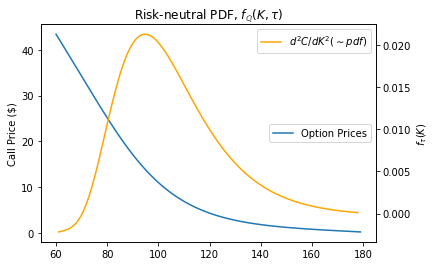

In [ ]:
# And plotting...
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
ax2 = ax.twinx()

ax.plot(strikes, option_prices, label='Option Prices')
ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')

ax.legend(loc="center right")
ax2.legend(loc="upper right")
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

## Let's compare with QuantLib Heston Model
<b>References:</b>
Stack Exchange Question, Computing the Probability Density Function (PDF) for the Heston model
https://quant.stackexchange.com/questions/57827/computing-the-probability-density-function-pdf-for-the-heston-model

Text(0.5, 1.0, 'QuantLib: Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

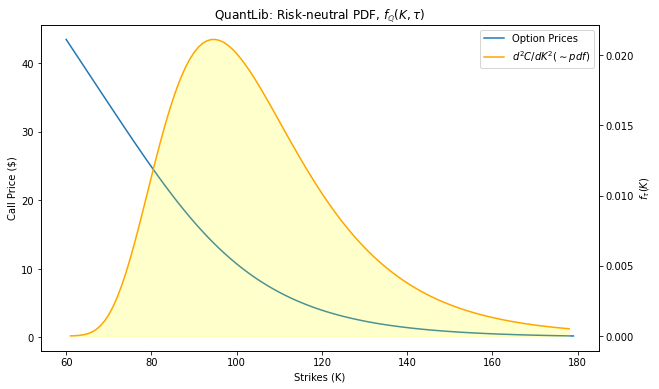

In [ ]:
import QuantLib as ql
today = ql.Date(28, 5, 2022)
expiry_date = today + ql.Period(int(365*tau), ql.Days)

# Setting up discount curve
risk_free_curve = ql.FlatForward(today, r, ql.Actual365Fixed())
flat_curve = ql.FlatForward(today, 0.0, ql.Actual365Fixed())
riskfree_ts = ql.YieldTermStructureHandle(risk_free_curve)
dividend_ts = ql.YieldTermStructureHandle(flat_curve)

# Setting up a Heston model
heston_process = ql.HestonProcess(riskfree_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(S0)), v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Now doing some pricing and curvature calculations
vols = [heston_vol_surface.blackVol(tau, x) for x in strikes]

option_prices1 = []
for strike in strikes:
    option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(expiry_date))

    heston_engine = ql.AnalyticHestonEngine(heston_model)
    option.setPricingEngine(heston_engine)

    option_prices1.append(option.NPV())

prices = pd.DataFrame([strikes, option_prices, option_prices1]).transpose()
prices.columns = ['strike', 'Rectangular Int','QuantLib']
prices['curvature'] = (-2 * prices['QuantLib'] + prices['QuantLib'].shift(1) + prices['QuantLib'].shift(-1)) / 1**2

# And plotting...
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
plt.xlabel('Strikes (K)')
ax2 = ax.twinx()
lns1 = ax.plot(strikes, option_prices1, label='Option Prices')
lns2 = ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')
ax2.fill_between(prices['strike'], prices['curvature'], color='yellow', alpha=0.2)

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# ax.legend(loc="center right")
# ax2.legend(loc="upper right")
plt.ylabel('$f_\\tau(K)$')
plt.title('QuantLib: Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

## What are the differences? - and why

In [ ]:
mse = np.mean( (option_prices - option_prices1)**2 )
print("QuantLib vs. Our Rect Int \n   Mean Squared Error: ", mse)
prices.dropna()
prices.head(40)

QuantLib vs. Our Rect Int 
   Mean Squared Error:  0.07222755594221925


,strike,Rectangular Int,QuantLib,curvature
0,60.0,43.381100,43.494129,NaN
1,61.0,42.473709,42.552367,0.000007
2,62.0,41.564129,41.610613,0.000017
3,63.0,40.652428,40.668875,0.000039
4,64.0,39.738685,39.727176,0.000082
5,65.0,38.822998,38.785559,0.000156
6,66.0,37.905495,37.844097,0.000276
7,67.0,36.986351,36.902911,0.000457
8,68.0,36.065806,35.962182,0.000716
9,69.0,35.144180,35.022169,0.001068


The differences are mainly a result of the method of complex integration over very small increments.
Python has issues with round off errors at small values approximated by binary floating-point numbers.

https://stackoverflow.com/questions/15930381/python-round-off-error

https://docs.python.org/3/tutorial/floatingpoint.html

In [ ]:
inter = prices.dropna()

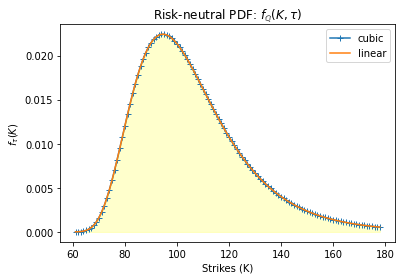

In [ ]:
pdf = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'linear')
pdfc = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'cubic')

strikes = np.arange(61, 179, 1.0)

plt.plot(strikes, pdfc(strikes), '-+', label='cubic')
plt.plot(strikes, pdf(strikes), label='linear')
plt.fill_between(strikes, pdf(strikes), color='yellow', alpha=0.2)
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF: $f_\mathbb{Q}(K, \\tau)$')
plt.legend()
plt.show()

### Cumulative distribution function

Text(0.5, 1.0, 'Risk-neutral CDF: $F_\\mathbb{Q}(K, \\tau)$')

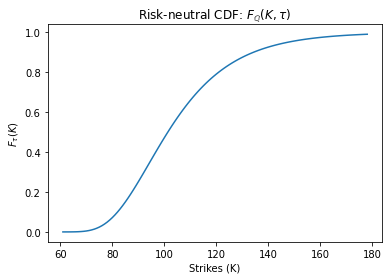

In [ ]:
cdf = sc.interpolate.interp1d(inter.strike, np.cumsum(pdf(strikes)), kind = 'linear')

plt.plot(strikes, cdf(strikes))

plt.xlabel('Strikes (K)')
plt.ylabel('$F_\\tau(K)$')
plt.title('Risk-neutral CDF: $F_\mathbb{Q}(K, \\tau)$')

## Using the Risk-neutral PDF to price 'complex' derivatives

Remember the RND function $f^{\tau}_\mathbb{Q}(S_T)$ is defined at a particular time to expiry $\tau$

### Call
$\large C(K, \tau) = e^{-r\tau} \int^\infty_K (S_T - K)f^{\tau}_\mathbb{Q}(S_T)dS_T$

### Put
$\large P(K, \tau) = e^{-r\tau} \int^K_{-\infty} (K - S_T)f^{\tau}_\mathbb{Q}(S_T)dS_T$

http://econweb.rutgers.edu/mizrach/pubs/%5B42%5D-2010_Handbook.pdf

In [ ]:
def integrand_call(x, K):
        return (x-K)*pdf(x)

def integrand_put(x, K):
        return (K-x)*pdf(x)

calls, puts = [], []
for K in strikes:
    # integral from K to infinity (looking at CDF, 179 last defined value on range)
    call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)

    # integral from -infinity to K (looking at CDF, 61 lowest defined value on range)
    put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)

    call = np.exp(-r*tau)*call_int
    calls.append( call )

    put = np.exp(-r*tau)*put_int
    puts.append( put )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


In [ ]:
rnd_prices = pd.DataFrame([strikes, calls, puts]).transpose()
rnd_prices.columns = ['strike', 'Calls','Puts']
rnd_prices.tail()

,strike,Calls,Puts
113,174.0,0.004409,64.141695
114,175.0,0.002437,65.070985
115,176.0,0.001064,66.000836
116,177.0,0.000261,66.931232
117,178.0,0.000000,67.862238
